# Decision Trees

Visualizing decision trees in this notebook requires <b>pydotplus</b> package. Install it and then restart this notebook's kernel, if you haven't already.

## Example 1: Predict Candidate Hiring Result

Use Pandas to convert a CSV file into a DataFrame:

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

input_file = "Past_Hires.csv"
df = pd.read_csv(input_file, header = 0)

C:\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
df.head()

,Years Experience,Employed?,Previous employers,Level of Education,Top-tier school,Interned,Hired
0,10,Y,4,BS,N,N,Y
1,0,N,0,BS,Y,Y,Y
2,7,N,6,BS,N,N,N
3,2,Y,1,MS,Y,N,Y
4,20,N,2,PhD,Y,N,N


SciKit-Learn needs everything to be numerical for decision trees to work. So, map Y,N to 1,0 and levels of education to a scale of 0-2:

In [3]:
d = {'Y': 1, 'N': 0}
df['Hired'] = df['Hired'].map(d)
df['Employed?'] = df['Employed?'].map(d)
df['Top-tier school'] = df['Top-tier school'].map(d)
df['Interned'] = df['Interned'].map(d)
d = {'BS': 0, 'MS': 1, 'PhD': 2}
df['Level of Education'] = df['Level of Education'].map(d)
df.head()

,Years Experience,Employed?,Previous employers,Level of Education,Top-tier school,Interned,Hired
0,10,1,4,0,0,0,1
1,0,0,0,0,1,1,1
2,7,0,6,0,0,0,0
3,2,1,1,1,1,0,1
4,20,0,2,2,1,0,0


Separate the features from the target column that we're trying to bulid a decision tree for:

In [4]:
features = list(df.columns[:6])
features

['Years Experience',
 'Employed?',
 'Previous employers',
 'Level of Education',
 'Top-tier school',
 'Interned']

### Construct the Decision Tree

In [5]:
y = df["Hired"]
x = df[features]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x,y)

Display the decision tree:

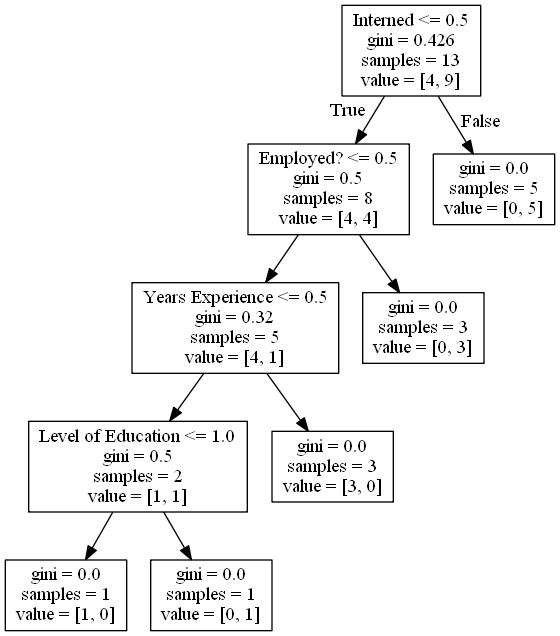

In [6]:
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

<b>How to read this decision tree?</b>

Each condition branches left for "true" and right for "false". The value array represents how many samples exist in each target value. So value = [x, y] means there are x "no hires" and y "hires" upto that point.

### Random Forests

Use a random forest of 10 decision trees to predict employment of specific candidate profiles:

In [7]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(x, y)

# Predict employment of an employed 10-year veteran
print (clf.predict([[10, 1, 4, 0, 0, 0]]))
# Predict employment of an unemployed 10-year veteran
print (clf.predict([[10, 0, 4, 0, 0, 0]]))

[1]
[0]


## Example 2: Predict Vehicle Speed Approaching a Bump

Fabricate the dataset

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs

n_samples = 10000

# Generate fabricated dataset (create two blobs of randomly distributed data at two corners of the graph):
centers = [(0.9, 0.05), (0.05, 0.94)]
x,y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=0.4,
                  centers=centers, shuffle=False, random_state=42)

# Filter out only the values that lie within [0,1]:
features = []
labels = []
for feature, label in zip(x,y):
    if (feature[0] >= 0 and feature[0] <= 1.0 and feature[1] >= 0 and feature[1] <= 1.0):
        features.append(feature)
        labels.append(label)

# Convert the results back into numpy arrays:
x = np.array(features)
y = np.array(labels)

### Construct the Decision Tree

In [9]:
clf = tree.DecisionTreeClassifier()
clf.fit(x,y)

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=['Distance', 'Bump Size'])  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Yikes, that's incredibly complicated! Given the very simple relationship that's inherent in the data (go slower when you get close to a big bump), this really looks like overfitting. 

Plot the categorizations this decision tree model results in, so as to visualize just how badly it is overfitting:

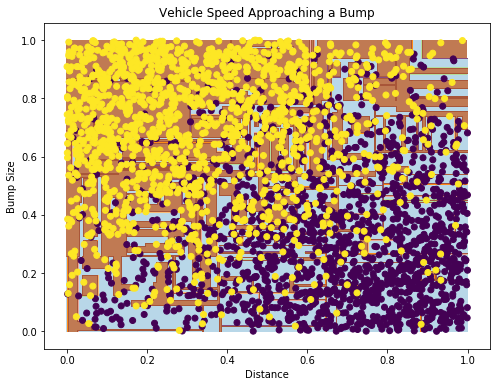

In [10]:
def plotPredictions(clf):
    xx, yy = np.meshgrid(np.arange(0, 1.0, 0.001),
                     np.arange(0, 1.0, 0.001))
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 6))
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(x[:,0], x[:,1], c=y.astype(np.float))
    plt.xlabel('Distance')
    plt.ylabel('Bump Size')
    plt.title("Vehicle Speed Approaching a Bump")
    plt.show()
    
plotPredictions(clf)

### k-Fold Cross Validation

In [11]:
from sklearn.model_selection import cross_val_score

fold_scores = cross_val_score(clf, x, y, cv=5)
print (fold_scores)
print (np.mean(fold_scores))

[0.77540984 0.76393443 0.77011494 0.75041051 0.77175698]
0.7663253385017093


### Random Forests

In [12]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(x, y)

fold_scores = cross_val_score(clf, x, y, cv=5)
print (fold_scores)
print (np.mean(fold_scores))

[0.81967213 0.80655738 0.81773399 0.79146141 0.80952381]
0.8089897440038764
